导入可能使用到的模块

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import joblib

读取数据集，并用train_test_split分割成9:1的数据

In [2]:
path = u"3_train.csv"
df = pd.read_csv(path, index_col=0)
m, n = df.shape
X = df.iloc[:, 0 : n - 1]
Y = df.iloc[:, n - 1]
X_type = list(X.columns)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

下面这个函数是用来显示三项数据（TV，radio和newspaper）各自与销量的关系的，由图和相关系数矩阵可见前两项与销量关系较为密切，而第三项数据则相关性较低

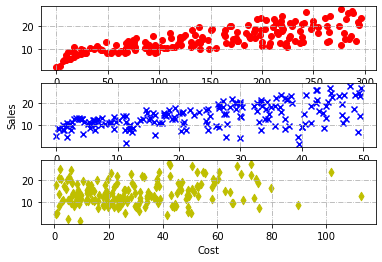

,TV,radio,newspaper,sales
TV,1.000000,0.042934,0.021903,0.775351
radio,0.042934,1.000000,0.372282,0.563953
newspaper,0.021903,0.372282,1.000000,0.217399
sales,0.775351,0.563953,0.217399,1.000000


In [3]:
def DataVisualize(df):
    plt.figure()
    plt.subplot(311)
    plt.scatter(df.TV, df.sales,  c='r',marker='o')
    plt.grid(linestyle='-.')
    plt.subplot(312)
    plt.scatter(df.radio, df.sales,  c='b', marker='x')
    plt.grid(linestyle='-.')
    plt.ylabel("Sales")
    plt.subplot(313)
    plt.scatter(df.newspaper, df.sales,  c='y', marker='d')
    plt.xlabel('Cost')
    plt.grid(linestyle='-.')
    plt.show()

DataVisualize(df)
# 输出相关系数矩阵（最后一行为三种参数（TV，radio，newspaper）对sales的相关系数（0~1之间），越小则说明越不相关
df.corr()

reg0 是一个使用最小二乘法实现的线性回归估计器，我们比对的参数有均方差（MSE，越低越好）以及用于评判相关度的R平方（R2，越接近 1 越好），这两个数据后续也会作为模型评估参数进行比对

In [4]:
# Now is (1, X1, X2, X3, X1 ^ 2, X1 * X2, X1 * X3, X2 ^ 2, X2 * X3, X3 ^ 2) 10 Features in total, so do coefs
# reg = lm.LinearRegression(copy_X=True)
reg0 = make_pipeline(PolynomialFeatures(degree=2), lm.LinearRegression(copy_X=True))
reg0.fit(X_train, Y_train)
coef = reg0[1].coef_
intercept = reg0[1].intercept_
train_score = reg0.score(X_train, Y_train)
test_score = reg0.score(X_test, Y_test)
train_mse = mean_squared_error(Y_train, reg0.predict(X_train))
test_mse = mean_squared_error(Y_test, reg0.predict(X_test))
print("Coef :", coef, "\tIntercept :", intercept)
print("Train R2 :", train_score, "\tTrain MSE :", train_mse)
print("Test R2 :", test_score, "\tTest MSE :", test_mse)

Coef : [ 0.00000000e+00  5.37063818e-02 -2.13398289e-04  1.09397502e-02
 -1.13396524e-04  1.09872450e-03 -4.21707247e-05  6.90510737e-04
 -1.18234399e-04  5.02577512e-05] 	Intercept : 4.946006835079711
Train R2 : 0.9704545335772526 	Train MSE : 0.8318010078481294
Test R2 : 0.9728846253797229 	Test MSE : 0.7476602776084341


以下两种都是十折交叉验证：

这是第一种交叉验证方法：cross_validate函数，它把所有重新划分和拟合以及测试的过程连在了一起，输出结果字典cv_results

注意：ShuffleSplit(n_splits=10, test_size=0.1, random_state=1) 并不保证每一次不出现重复数据，故并不适用于十次十折交叉验证

所以我们在这里使用了KFold(n_splits=10, shuffle=True, random_state=1)，这个可以保证每次划分随机但不重复，只需要更改随机数种子即可适用于十次十折交叉验证

In [5]:
# Cross Validation Method 1
cv_results = cross_validate(reg0, X, Y, cv=KFold(n_splits=10, shuffle=True, random_state=1), scoring=['neg_mean_squared_error','r2'], return_train_score=True, return_estimator=True)
cv_results = pd.DataFrame(cv_results)
train_mse_mean = cv_results['train_neg_mean_squared_error'].mean() * (-1.0)
test_mse_mean = cv_results['test_neg_mean_squared_error'].mean() * (-1.0)
train_score_mean = cv_results['train_r2'].mean()
test_score_mean = cv_results['test_r2'].mean()
cv_results.rename(columns={'train_neg_mean_squared_error' : 'train_negMSE', 'test_neg_mean_squared_error': 'test_negMSE'}, inplace=True)
print(cv_results.drop(columns=['estimator']),"\n")
print("Mean Train MSE: %.6f, Mean Test MSE: %.6f" % (train_mse_mean, test_mse_mean))
print("Mean Train R2: %.6f, Mean Test R2: %.6f\n" % (train_score_mean, test_score_mean))

estimators = cv_results['estimator']
coef_list = []
intercept_list = []
for i in estimators:
    coef_list.append(i[1].coef_)
    intercept_list.append(i[1].intercept_)
coef_mean = np.array(coef_list).mean(axis=0)
intercept_mean = np.array(intercept_list).mean()
print("Coef :", coef_mean, "\tIntercept :", intercept_mean, "\n")

   fit_time  score_time  test_negMSE  train_negMSE   test_r2  train_r2
0  0.017003    0.006001    -0.747660     -0.831801  0.972885  0.970455
1  0.012003    0.007002    -1.984193     -0.710330  0.944533  0.973908
2  0.011002    0.005002    -1.117763     -0.787572  0.937094  0.972480
3  0.010002    0.004000    -0.597091     -0.843926  0.966006  0.970956
4  0.010001    0.005002    -0.471678     -0.858268  0.976077  0.970302
5  0.011004    0.006000    -0.704203     -0.835434  0.975694  0.969934
6  0.010003    0.006001    -0.498721     -0.855314  0.968026  0.970831
7  0.011001    0.005002    -0.702007     -0.831266  0.974876  0.970423
8  0.010004    0.004998    -1.743242     -0.716285  0.958755  0.972991
9  0.009003    0.006001    -0.692677     -0.835616  0.981154  0.969199 

Mean Train MSE: 0.810581, Mean Test MSE: 0.925924
Mean Train R2: 0.971148, Mean Test R2: 0.965510

Coef : [ 0.00000000e+00  5.31758253e-02  2.72743446e-04  3.34439250e-03
 -1.12407339e-04  1.09778072e-03 -3.79723619e-

这是第二种交叉验证方法：KFold类，它可以输出每一次交叉验证的划分

In [6]:
# Cross Validation Method 2
kf = KFold(n_splits=10, shuffle=True, random_state=1)
i = 1
coef_list = []
intercept_list = []
test_score_list = []
test_mse_list = []
train_score_list = []
train_mse_list = []
all_score_list = []
all_mse_list= []
for train_index, test_index in kf.split(X, Y):
    print("%d out of KFold %d" % (i, kf.n_splits), end='\t')
    print("TEST_INDEX :", test_index)
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
    # reg = lm.LinearRegression(copy_X=True)
    reg = make_pipeline(PolynomialFeatures(degree=2), lm.LinearRegression(copy_X=True))
    reg.fit(X_train, Y_train)
    
    test_score = reg.score(X_test, Y_test)
    train_score = reg.score(X_train, Y_train)
    all_score = reg.score(X, Y)
    test_mse = mean_squared_error(Y_test, reg.predict(X_test))
    train_mse = mean_squared_error(Y_train, reg.predict(X_train))
    all_mse = mean_squared_error(Y, reg.predict(X))
    print("Train R2: %.6f, Test R2: %.6f, All R2: %.6f, Train MSE: %.6f, Test MSE: %.6f,  All MSE: %.6f" % (train_score, test_score, all_score, train_mse, test_mse, all_mse))
    
    coef_list.append(reg[1].coef_)
    intercept_list.append(reg[1].intercept_)
    
    test_score_list.append(test_score)
    test_mse_list.append(test_mse)
    train_score_list.append(train_score)
    train_mse_list.append(train_mse)
    all_score_list.append(all_score)
    all_mse_list.append(all_mse)
    
    i += 1

coef_mean = np.array(coef_list).mean(axis=0)
intercept_mean = np.array(intercept_list).mean()

test_score_mean = np.array(test_score_list).mean()
test_mse_mean = np.array(test_mse_list).mean()
train_score_mean = np.array(train_score_list).mean()
train_mse_mean = np.array(train_mse_list).mean()
all_score_mean = np.array(all_score_list).mean()
all_mse_mean = np.array(all_mse_list).mean()
# Parameters
print("\nCoef Mean: ", coef_mean)
print("Intercept Mean: ", intercept_mean, "\n")
# Mean Scores
print("Train R2 Mean: ", train_score_mean)
print("Test R2 Mean: ", test_score_mean)
print("All R2 Mean: ", all_score_mean, "\n")
print("Train MSE Mean: ", train_mse_mean)
print("Test MSE Mean: ", test_mse_mean)
print("All MSE Mean: ", all_mse_mean)

1 out of KFold 10	TEST_INDEX : [  4  11  14  19  35  54  69  99 106 107 108 110 112 116 120 124 127 161]
Train R2: 0.970455, Test R2: 0.972885, All R2: 0.970693, Train MSE: 0.831801, Test MSE: 0.747660,  All MSE: 0.823387
2 out of KFold 10	TEST_INDEX : [  5  16  29  31  40  42  48  51  53  56  66  94  95 123 158 159 167 174]
Train R2: 0.973908, Test R2: 0.944533, All R2: 0.970183, Train MSE: 0.710330, Test MSE: 1.984193,  All MSE: 0.837716
3 out of KFold 10	TEST_INDEX : [ 18  33  39  44  47  58  59  81  84  90 117 118 132 150 153 154 172 178]
Train R2: 0.972480, Test R2: 0.937094, All R2: 0.970793, Train MSE: 0.787572, Test MSE: 1.117763,  All MSE: 0.820591
4 out of KFold 10	TEST_INDEX : [ 12  13  17  28  36  45  73  82  85  89  91  93 114 126 130 148 164 166]
Train R2: 0.970956, Test R2: 0.966006, All R2: 0.970841, Train MSE: 0.843926, Test MSE: 0.597091,  All MSE: 0.819243
5 out of KFold 10	TEST_INDEX : [  0   2   6  21  65  70  75  77  78  97 135 136 138 143 168 173 175 177]
Train R

其实上面两种方法得到的结果是一样的 :)

下面则是将上面每次结果一起可视化得到的柱形图，可以发现R2基本都在0.95以上，说明估计器能很好地拟合这些数据

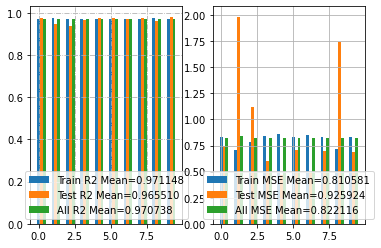

In [7]:
bar_width = 0.2
N = 10
plt.subplot(1, 2, 1)
plt.grid(linestyle='-.')
plt.bar(np.arange(N), height=train_score_list, width=bar_width, label='Train R2 Mean=%.6f' % train_score_mean)
plt.bar(np.arange(N) + bar_width, height=test_score_list, width=bar_width, align='center', label='Test R2 Mean=%.6f' % test_score_mean)
plt.bar(np.arange(N) + 2 * bar_width, height=all_score_list, width=bar_width, align='center', label='All R2 Mean=%.6f' % all_score_mean)
plt.legend(loc='lower center')

plt.subplot(1, 2, 2)
plt.grid()
plt.bar(np.arange(N), height=train_mse_list, width=bar_width, label='Train MSE Mean=%.6f' % train_mse_mean)
plt.bar(np.arange(N) + bar_width, height=test_mse_list, width=bar_width, align='center', label='Test MSE Mean=%.6f' % test_mse_mean)
plt.bar(np.arange(N) + 2 * bar_width, height=all_mse_list, width=bar_width, align='center', label='All MSE Mean=%.6f' % all_mse_mean)
plt.legend(loc='lower center')

plt.show()

执行十次十折交叉验证：

In [8]:
def TenTimesTenFoldsCV(X, Y, polynomial=False):
    import sklearn.linear_model as lm
    from sklearn.model_selection import cross_validate, KFold
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.pipeline import make_pipeline
    import numpy as np
    
    cv_results_dict = {}
    coef_dict = {}
    intercept_dict = {}
    estimator_dict = {}
    scoring_dict={}
    
    if polynomial == True:
        reg = make_pipeline(PolynomialFeatures(degree=2), lm.LinearRegression(copy_X=True))
    else:
        reg = lm.LinearRegression()
    
    for i in range(10):
        # Cross Validation Method 1
        print("Times %d:" % (i + 1))
        cv_results = cross_validate(reg, X, Y, cv=KFold(n_splits=10, shuffle=True, random_state=i), scoring=['neg_mean_squared_error','r2'], return_train_score=True, return_estimator=True)
        cv_results = pd.DataFrame(cv_results)
        cv_results_dict[i] = cv_results
        
        train_mse_mean = cv_results['train_neg_mean_squared_error'].mean() * (-1.0)
        test_mse_mean = cv_results['test_neg_mean_squared_error'].mean() * (-1.0)
        train_score_mean = cv_results['train_r2'].mean()
        test_score_mean = cv_results['test_r2'].mean()
        scoring_dict[i] = {'train_mse_mean': train_mse_mean, 'test_mse_mean': test_mse_mean, 'train_score_mean': train_score_mean, 'test_score_mean': test_score_mean}
        
        cv_results.rename(columns={'train_neg_mean_squared_error' : 'train_negMSE', 'test_neg_mean_squared_error': 'test_negMSE'}, inplace=True)
        # If print these, results will be too long to read :(
        # print(cv_results.drop(columns=['estimator']),"\n")
        
        print("Mean Train MSE: %.6f, Mean Test MSE: %.6f" % (train_mse_mean, test_mse_mean))
        print("Mean Train R2: %.6f, Mean Test R2: %.6f\n" % (train_score_mean, test_score_mean))
        
        estimators = cv_results['estimator']
        estimator_dict[i] = estimators
        
        coef_list = []
        intercept_list = []
        if polynomial == True:
            for e in estimators:
                coef_list.append(e[1].coef_)
                intercept_list.append(e[1].intercept_)
        else:
            for e in estimators:
                coef_list.append(e.coef_)
                intercept_list.append(e.intercept_)
        
        coef_mean = np.array(coef_list).mean(axis=0)
        intercept_mean = np.array(intercept_list).mean()
        
        coef_dict[i] = coef_mean
        intercept_dict[i] = intercept_mean
        
        print("Coef :", coef_mean, "\tIntercept :", intercept_mean, "\n")
    return (cv_results_dict, coef_dict, intercept_dict, estimator_dict, scoring_dict)

_, coef_dict, intercept_dict, _, scoring_dict = TenTimesTenFoldsCV(X, Y, polynomial=True)

# coef_mean = np.array(pd.DataFrame(coef_dict).mean(axis=1))
coef_mean = np.array(list(coef_dict.values())).mean(axis=0)
intercept_mean = np.array(list(intercept_dict.values())).mean()

print("Final Coef Mean :", coef_mean)
print("Final Intercept Mean :", intercept_mean)

Times 1:
Mean Train MSE: 0.809157, Mean Test MSE: 0.954955
Mean Train R2: 0.971183, Mean Test R2: 0.964670

Coef : [ 0.00000000e+00  5.31599930e-02 -3.67835877e-05  3.09406646e-03
 -1.12375314e-04  1.09905225e-03 -3.88621577e-05  6.38958221e-04
  8.35077114e-05  4.24967724e-05] 	Intercept : 5.052341413205953 

Times 2:
Mean Train MSE: 0.810581, Mean Test MSE: 0.925924
Mean Train R2: 0.971148, Mean Test R2: 0.965510

Coef : [ 0.00000000e+00  5.31758253e-02  2.72743446e-04  3.34439250e-03
 -1.12407339e-04  1.09778072e-03 -3.79723619e-05  6.39904627e-04
  8.25632849e-05  3.68096051e-05] 	Intercept : 5.044451893130786 

Times 3:
Mean Train MSE: 0.809014, Mean Test MSE: 0.958838
Mean Train R2: 0.971141, Mean Test R2: 0.960633

Coef : [ 0.00000000e+00  5.31618197e-02  3.56049983e-04  3.32444982e-03
 -1.12374638e-04  1.09845614e-03 -3.82781072e-05  6.42656771e-04
  7.17341066e-05  4.08737878e-05] 	Intercept : 5.043448973204627 

Times 4:
Mean Train MSE: 0.810269, Mean Test MSE: 0.932869
Mean 

将得到的平均权值与偏置用于建立一个新估计器，在重新随机划分的数据集上再运行一次并输出MSE和R2，可以看到取十次十折交叉验证的权值和偏置的平均数作为新估计器的参数后，对测试集评估时所获得的MSE和R2都有了改善

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)
reg0.coef_ = coef_mean
reg0.intercept_ = intercept_mean
# reg0.singular_ = singular_mean
Y_pred = reg0.predict(X)
print("After changing weights and bias to meaned edition:")
print("Train R2 :", reg0.score(X_train, Y_train))
print("Test R2 :", reg0.score(X_test, Y_test))
print("All R2 :", reg0.score(X, Y))
print("Train MSE :", mean_squared_error(Y_train, reg0.predict(X_train)))
print("Test MSE :", mean_squared_error(Y_test, reg0.predict(X_test)))
print("All MSE :", mean_squared_error(Y, Y_pred))

After changing weights and bias to meaned edition:
Train R2 : 0.9704545335772526
Test R2 : 0.9728846253797229
All R2 : 0.9706930290108474
Train MSE : 0.8318010078481294
Test MSE : 0.7476602776084341
All MSE : 0.82338693482416


以第二种方法的运行后所得数据，输出最终方程

In [10]:
polynomial_items = [i.replace('X1', X_type[0]).replace('X2', X_type[1]).replace('X3', X_type[2]) for i in ['1', 'X1', 'X2', 'X3', 'X1 ^ 2', 'X1 * X2', 'X1 * X3', 'X2 ^ 2', 'X2 * X3', 'X3 ^ 2']]
finalEqStr = ""
for i in range(1, len(polynomial_items)):
	finalEqStr += "(%.6f) * %s + " % (coef_mean[i], polynomial_items[i])
finalEqStr += str(intercept_mean)
print("Final Equation : Sales =", finalEqStr, "\n")

Final Equation : Sales = (0.053131) * TV + (0.000039) * radio + (0.003022) * newspaper + (-0.000112) * TV ^ 2 + (0.001099) * TV * radio + (-0.000038) * TV * newspaper + (0.000640) * radio ^ 2 + (0.000082) * radio * newspaper + (0.000042) * newspaper ^ 2 + 5.054849901010176 



以下为存取模型的函数调用方法：

Example 1：将这个新估计器保存到同目录下的LinearRegressor.pkl文件中

In [11]:
joblib.dump(reg0, "LinearRegressor.pkl")

['LinearRegressor.pkl']

Example 2：使用下列命令将其重新读取入内存中

In [12]:
reg0 = joblib.load("LinearRegressor.pkl")

以下为测试函数，注意：本notebook中一直使用pd.DataFrame和pd.Series来存放X和Y的数据，故sklearn的估计器中存有特征列的名称，下文报错在np.array上发生是正常现象，但不影响函数返回值。

In [13]:
def tester(reg, data):
    """
    Input:
    reg: Regressor from sklearn with predict() method, e.g. sklearn.linear_model._base.LinearRegression() or Pipeline()
    data: np.array of (n, 4), e.g. array([[X1, X2, X3, Y]])
          or list e.g. [(X1, X2, X3, Y1), (X4, X5, X6, Y2)]
    
    Return: (Y_pred, mse)
    Y_pred: Predicted Values of Y
    mse: Mean Squared Error Value of (Y, Y_pred)
    """
    from sklearn.metrics import mean_squared_error
    data = np.array(data) # Ensure that input data is an np.ndarray
    m, n = data.shape
    X, Y = data[:, 0 : n - 1], data[:, n - 1]
    Y_pred = reg.predict(X)
    mse = mean_squared_error(Y, Y_pred)
    return (Y_pred, mse)

In [14]:
# Get Data Ready For Function tester()
X1 = np.array(X_test)
Y1 = np.array(Y_test)
print(X1.shape, Y1.shape)
# Y1 should be 2-dim array of (n, 1), change it now
Y1 = Y1.reshape(Y1.shape[0], 1)
data = np.hstack([X1, Y1])
print(data.shape)

(18, 3) (18,)
(18, 4)


In [15]:
#Try tester()
Y1_pred, mse1 = tester(reg0, data)

In [16]:
print(Y1_pred, mse1)

[13.95373503  6.61972792 18.7094405  12.72052447 14.93745021  9.07095458
 18.83978519 20.53711924 13.61456001  9.51257141 22.67258717 18.34166043
 10.64704921 10.99212234 11.92843152 18.67614835 23.93979674  7.83979225] 0.7476602776084341


PS: mean_squared_error() 计算值即为MSE公式的方法：（预测 - 实际）^ 2 的求和除以数据个数

$MSE(X,h_\theta) = \frac{1}{m}\sum_{i=1}^m(\theta^T \cdot x^{(i)} - y^{(i)})^2$

In [17]:
Y2 = Y1_pred - Y1.reshape(-1)
loss = np.sum(Y2**2) / Y2.shape[0]
print(loss)
print(mse1==loss)

0.7476602776084341
True


如下图所示，以X的前两项数据（TV，radio）与Y（Sales销量）的预测值分别为X，Y，Z轴的图像显示出模型能很好地拟合原始数据
PS：蓝点为原始值，绿点为预测值

而以X的（TV，radio，newspaper）与Y（Sales销量）的预测值分别为X，Y轴生成的三张图像也显示出模型的拟合能力很好
PS：红点为原始值，蓝点为预测值

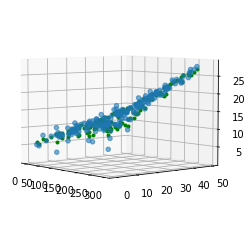

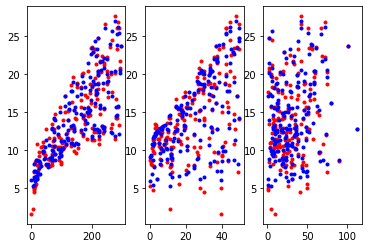

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter3D(X.iloc[:, 0], X.iloc[:, 1], Y, cmap='Blues', alpha=0.6)
ax1.plot3D(X.iloc[:, 0], X.iloc[:, 1], Y_pred, '.g', alpha=1)
ax1.view_init(5, -40)
plt.show()

fig = plt.figure()
ax2 = fig.add_subplot(131) 
ax2.plot(X.iloc[:, 0], Y, '.r', X.iloc[:, 0], Y_pred, '.b')
ax2 = fig.add_subplot(132)
ax2.plot(X.iloc[:, 1], Y, '.r', X.iloc[:, 1], Y_pred, '.b')
ax2 = fig.add_subplot(133)
ax2.plot(X.iloc[:, 2], Y, '.r', X.iloc[:, 2], Y_pred, '.b')
plt.show()